In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import pickle
import uproot3 as uproot


In [2]:
# v2 compares a smaller number of variation types
# and checks Np and 0p separately
# and checks NC Pi0 events in the nu_overlay file

# v3 adds runs 1 and 3 (was just run 1)

# v4 looks at gLEE selections too


In [3]:
bdt_vars = ["nc_delta_score", "nue_score", "numu_score"]

eval_vars = [
    "run",
    "subrun",
    "event",
    "weight_spline",
    "weight_cv",
    "truth_nuEnergy",
    "truth_nuPdg",
    "truth_isCC",
    "truth_vtxInside",
    "match_isFC",

    "gl_sel_type",
    "gl_reco_Eshower",
]

pf_eval_vars = [
    "truth_NprimPio",
    "truth_NCDelta",
    "reco_showerKE",
]

kine_vars = [
    "kine_reco_Enu",
    "kine_energy_particle",
    "kine_particle_type",
]



no 3a nc_delta_overlay file, continuing...
no 3b nc_delta_overlay file, continuing...
no 3a nc_pi0_overlay file, continuing...
no 3b nc_pi0_overlay file, continuing...
no 3a nu_overlay file, continuing...
no 3a nc_pi0_in_nu_overlay file, continuing...
no 3a nc_pi0_in_nu_overlay_outFV file, continuing...


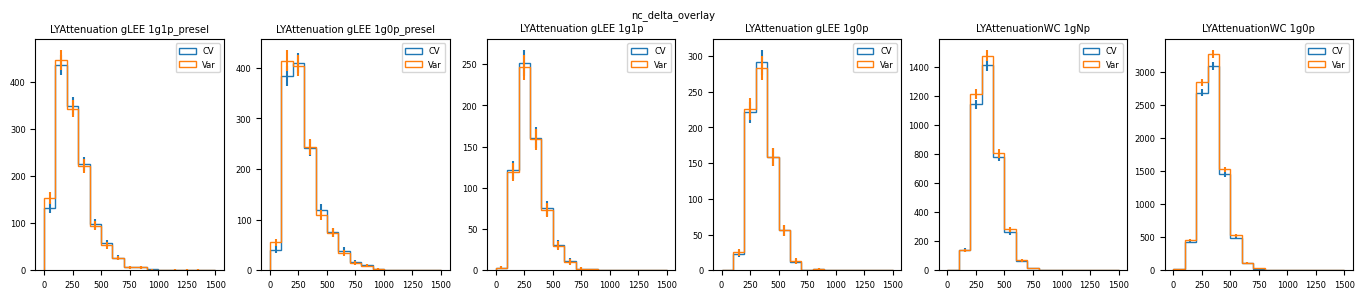

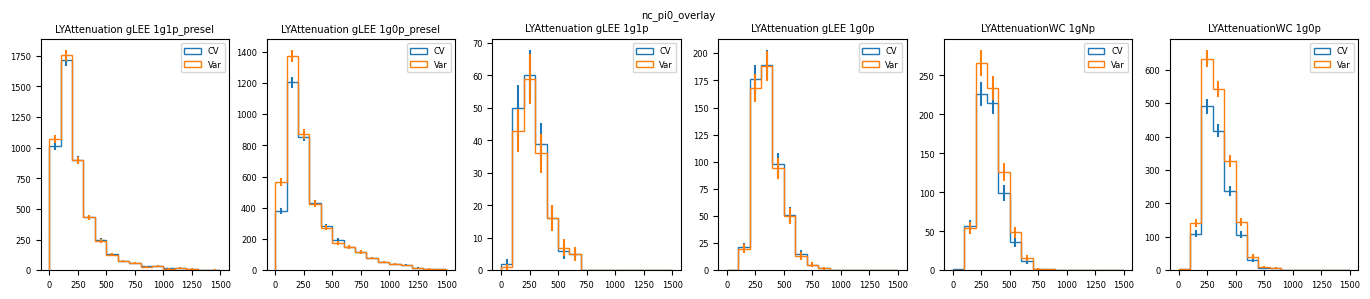

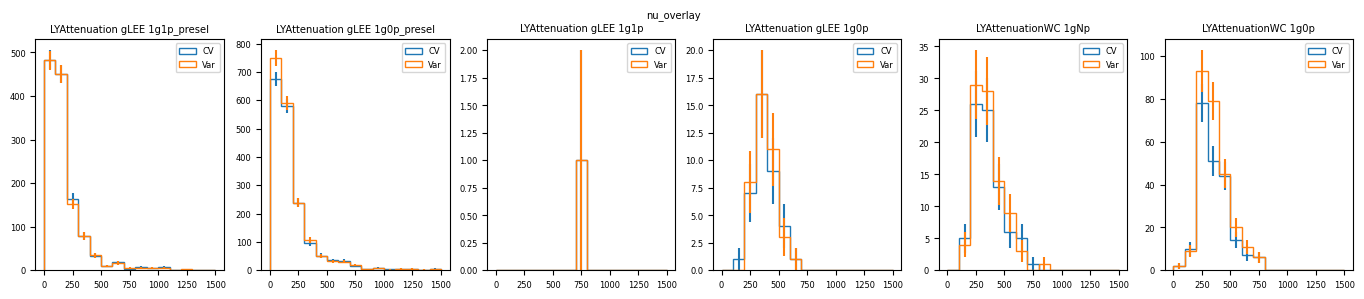

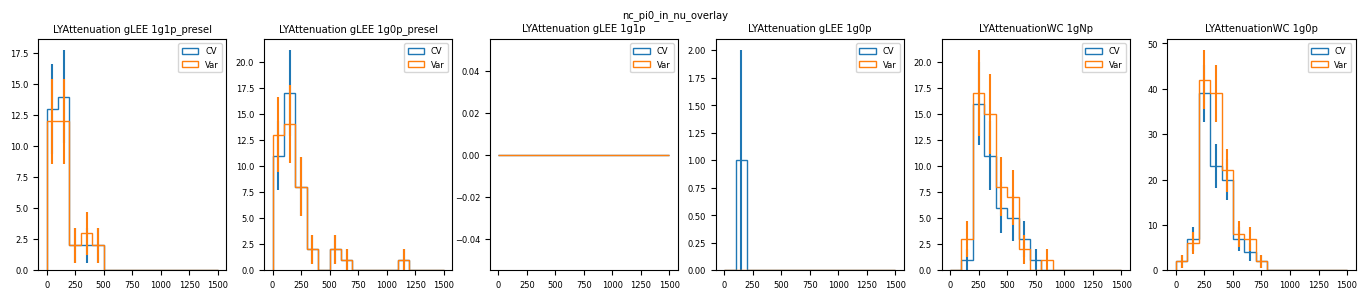

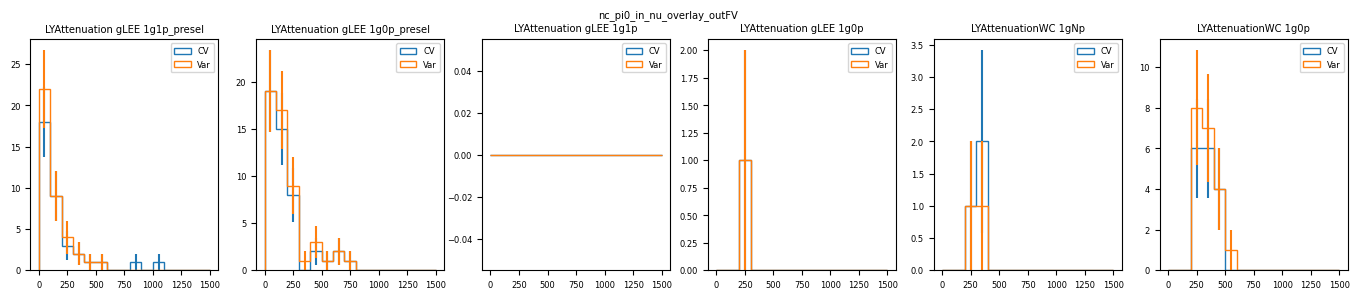

In [4]:
#detvar_loc = "/home/lee/hd1/glee_added_rootfiles_old_LYAtt_bug/glee_added_hist_rootfiles/DetVar/"
detvar_loc = "/home/lee/hd1/glee_added_rootfiles/glee_added_hist_rootfiles/DetVar/"

#filetypes = ["nc_delta_overlay", "nc_pi0_overlay", "cc_pi0_overlay", "nue_overlay", "nu_overlay", "nc_pi0_in_nu_overlay", "nc_pi0_in_nu_overlay_outFV"]
filetypes = ["nc_delta_overlay", "nc_pi0_overlay", "nu_overlay", "nc_pi0_in_nu_overlay", "nc_pi0_in_nu_overlay_outFV"]
#vartype_wc_names = ["WireModThetaXZ", "WireModThetaYZ", "LYAttenuation", "LYDown", "LYRayleigh", "Recomb2", "SCE", "WireModX", "WireModYZ"]
vartype_wc_names = ["LYAttenuation"]

plt.rcParams.update({'font.size': 6})

for i in range(len(filetypes)):
    filetype = filetypes[i]

    #fig, axs = plt.subplots(nrows=1, ncols=9, figsize=(20, 3))
    fig, axs = plt.subplots(nrows=1, ncols=6, figsize=(17, 3))

    fig.suptitle(filetypes[i])

    for j in range(len(vartype_wc_names)):

        fname = detvar_loc + "WCPcheckout_prodgenie_bnb"

        if filetype == "nc_delta_overlay":
            fname += "_nc_delta_overlay"
        elif filetype == "nc_pi0_overlay":
            fname += "_nc_pi0_overlay"
        elif filetype == "cc_pi0_overlay":
            fname += "_cc_pi0_overlay"
        elif filetype == "nue_overlay":
            fname += "_intrinsic_nue_overlay"
        elif filetype == "nu_overlay":
            fname += "_nu_overlay"
        elif filetype == "nc_pi0_in_nu_overlay":
            fname += "_nu_overlay"
        elif filetype == "nc_pi0_in_nu_overlay_outFV":
            fname += "_nu_overlay"
        else:
            print("ERROR: unknown filetype", filetype)

        fname += "_WCP_DetVar_"

        fname += vartype_wc_names[j]

        for run_num in ["1", "3", "3a", "3b"]:
            try:
                #if run_num == 1:
                #    f = uproot.open(fname + f"_run{run_num}_disabled.root")["wcpselection"]
                #else:
                #    f = uproot.open(fname + f"_run{run_num}.root")["wcpselection"]
                f = uproot.open(fname + f"_run{run_num}.root")["wcpselection"]
                f_bdt = f["T_BDTvars_cv"].pandas.df(bdt_vars, flatten=False)
                f_eval = f["T_eval_cv"].pandas.df(eval_vars, flatten=False)
                f_pfeval = f["T_PFeval_cv"].pandas.df(pf_eval_vars, flatten=False)
                f_kine = f["T_KINEvars_cv"].pandas.df(kine_vars, flatten=False)
                sub_cv_df = pd.concat([f_bdt, f_eval, f_pfeval, f_kine], axis=1, sort=False)
                sub_cv_df["cv_or_var"] = ["CV" for _ in range(sub_cv_df.shape[0])]
                f_bdt = f["T_BDTvars_det"].pandas.df(bdt_vars, flatten=False)
                f_eval = f["T_eval_det"].pandas.df(eval_vars, flatten=False)
                f_pfeval = f["T_PFeval_det"].pandas.df(pf_eval_vars, flatten=False)
                f_kine = f["T_KINEvars_det"].pandas.df(kine_vars, flatten=False)
                sub_var_df = pd.concat([f_bdt, f_eval, f_pfeval, f_kine], axis=1, sort=False)
                del f
                del f_bdt
                del f_eval
                del f_pfeval
                del f_kine
                sub_var_df["cv_or_var"] = ["var" for _ in range(sub_var_df.shape[0])]

                if run_num == "1":
                    cv_df = sub_cv_df
                    var_df = sub_var_df
                else:
                    cv_df = pd.concat([cv_df, sub_cv_df])
                    var_df = pd.concat([var_df, sub_var_df])
            except:
                print(f"no {run_num} {filetype} file, continuing...")
                continue

        if filetype == "nc_pi0_in_nu_overlay":
            cv_df = cv_df.query("truth_isCC==0 and truth_NprimPio==1 and truth_vtxInside==1")
            var_df = var_df.query("truth_isCC==0 and truth_NprimPio==1 and truth_vtxInside==1")
        elif filetype == "nc_pi0_in_nu_overlay_outFV":
            cv_df = cv_df.query("truth_isCC==0 and truth_NprimPio==1 and truth_vtxInside==0")
            var_df = var_df.query("truth_isCC==0 and truth_NprimPio==1 and truth_vtxInside==0")

        for k in range(6):
            if k == 4 or k == 5:
                for df in [cv_df, var_df]:
                    proton_nums = []
                    energy_lists = df["kine_energy_particle"].to_numpy()
                    pdg_lists = df["kine_particle_type"].to_numpy()
                    for i in range(df.shape[0]):
                        proton_num = 0
                        energy_list = energy_lists[i]
                        pdg_list = pdg_lists[i]
                        for i in range(len(energy_list)):
                            if abs(pdg_list[i]) == 2212 and energy_list[i] > 35.:
                                proton_num += 1
                        proton_nums.append(proton_num)
                    df["WC_reco_num_protons"] = proton_nums

            if k == 0:
                cv_sel_df = cv_df.query("gl_sel_type == 3")
                var_sel_df = var_df.query("gl_sel_type == 3")
            elif k == 1:
                cv_sel_df = cv_df.query("gl_sel_type == 4")
                var_sel_df = var_df.query("gl_sel_type == 4")
            elif k == 2:
                cv_sel_df = cv_df.query("gl_sel_type == 1")
                var_sel_df = var_df.query("gl_sel_type == 1")
            elif k == 3:
                cv_sel_df = cv_df.query("gl_sel_type == 2")
                var_sel_df = var_df.query("gl_sel_type == 2")
            elif k == 4:
                cv_sel_df = cv_df.query("WC_reco_num_protons > 0 and kine_reco_Enu > 0 and match_isFC==1 and reco_showerKE > 0 and nc_delta_score > 2.61")
                var_sel_df = var_df.query("WC_reco_num_protons > 0 and kine_reco_Enu > 0 and match_isFC==1 and reco_showerKE > 0 and nc_delta_score > 2.61")
            elif k == 5:
                cv_sel_df = cv_df.query("WC_reco_num_protons == 0 and kine_reco_Enu > 0 and match_isFC==1 and reco_showerKE > 0 and nc_delta_score > 2.61")
                var_sel_df = var_df.query("WC_reco_num_protons == 0 and kine_reco_Enu > 0 and match_isFC==1 and reco_showerKE > 0 and nc_delta_score > 2.61")


            #bins = np.linspace(0, 1500, 16)
            bins = np.linspace(0, 1500, 16)
            bin_centers = (bins[1:] + bins[:-1]) / 2.
            if k == 4 or k == 5:
                n, _, _ = axs[k].hist(cv_sel_df["reco_showerKE"].to_numpy()*1000., bins=bins, histtype="step", label="CV", color="tab:blue")
                axs[k].errorbar(bin_centers, n, yerr=np.sqrt(n), fmt="none", c="tab:blue")
                n, _, _ = axs[k].hist(var_sel_df["reco_showerKE"].to_numpy()*1000., bins=bins, histtype="step", label="Var", color="tab:orange")
                axs[k].errorbar(bin_centers, n, yerr=np.sqrt(n), fmt="none", c="tab:orange")
            else:
                n, _, _ = axs[k].hist(cv_sel_df["gl_reco_Eshower"].to_numpy(), bins=bins, histtype="step", label="CV", color="tab:blue")
                axs[k].errorbar(bin_centers, n, yerr=np.sqrt(n), fmt="none", c="tab:blue")
                n, _, _ = axs[k].hist(var_sel_df["gl_reco_Eshower"].to_numpy(), bins=bins, histtype="step", label="Var", color="tab:orange")
                axs[k].errorbar(bin_centers, n, yerr=np.sqrt(n), fmt="none", c="tab:orange")

            axs[k].legend()
            #axs[j].set_ylabel("Number of Events (no GENIE weights)")
            #axs[j].set_xlabel("Reconstructed Shower Energy (MeV)")
            axs[k].set_title(vartype_wc_names[j] + [" gLEE 1g1p_presel", " gLEE 1g0p_presel", " gLEE 1g1p", " gLEE 1g0p", "WC 1gNp", "WC 1g0p"][k])

            #print(f"setting axis {j*3+k}")

plt.show()
